In [1]:
print(sc.uiWebUrl)

http://midway3-0078.rcc.local:4040


In [2]:
# --- Step 1.1: Spark session (safe defaults) ---
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = (
    SparkSession.builder
    .appName("peoples_daily_yearvecs")
    .config("spark.sql.shuffle.partitions", "112")  
    .getOrCreate()
)

25/11/03 15:45:03 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [3]:
# 1. 读取 parquet 数据
BASE_PATH = "cleaned_segmented_parquet"
df = spark.read.parquet(BASE_PATH)

# 2. 重命名（Spark 不支持 rename()，要用 withColumnRenamed！）
df = (df.withColumnRenamed("文本内容_清洗", "content_cleaned")
        .withColumnRenamed("年份", "year"))

# 3. 只保留 content_cleaned 和 year
df = df.select("content_cleaned", "year")

# 4. 确保 year 是整数型
df = df.withColumn("year", F.col("year").cast("int"))

# 5. 查看一下结构
print("Columns now:", df.columns)
df.printSchema()
df.show(5, truncate=80)


Columns now: ['content_cleaned', 'year']
root
 |-- content_cleaned: string (nullable = true)
 |-- year: integer (nullable = true)

+---------------------------------------------------------------------------------------------------------------------------------------+----+
|                                                                                                                        content_cleaned|year|
+---------------------------------------------------------------------------------------------------------------------------------------+----+
| 首届 动漫 版权保护 贸易 博览会 本报 广州 月 日电 记者 吴冰 贺林平 首届 中国 国际 影视 动漫 版权保护 贸易 博览会 东莞 这是 全国 第一...|2010|
|    数字 点击 成就 万吨 截至 年 月 日 大庆油田 年 生产 原油 万吨 天然气 亿立方米 原油 万吨 稳产 年 汪 波 宝 峰 亿元 财政部 会同 民政...|2010|
|     福建 铁路 三线 开通 六线 一站 开工 年 月 日 福厦 铁路 开通 建设者 欢呼雀跃 当日 福建 温 州 福 州 铁路 福厦 铁路 横 峰福 州 铁路...|2010|
|强化 廉政 意识 弘扬 新风 正气 深入开展 反腐倡廉 二 九年 反腐倡廉 宣传教育 工作 综述 本报记者 姜 洁 年 纪检监察 机关 贯彻落实 科学 发...|2010|
|   汽车 以旧换新 补贴 标准 上限 提高 万元 已 按原 标准 领取 补贴 车主 获补 差额 本报 北京 月 日电 记者 崔鹏 完善 汽车 以旧换新 

In [4]:
# --- Step 2.1: Filter to year 1947 and cache ---
df_1947 = (df
    .filter(F.col("year") == 1947)
    .filter(F.col("content_cleaned").isNotNull())
    .filter(F.length(F.trim(F.col("content_cleaned"))) > 0)
    .cache()
)

n_47 = df_1947.count()
print(f"[1947] rows (non-empty): {n_47}")

# --- Step 2.2: Basic length stats (characters & tokens) ---
# If content_cleaned is whitespace-tokenized, token count is reliable.
df_1947_len = (df_1947
    .withColumn("char_len", F.length(F.col("content_cleaned")))
    .withColumn("token_len", F.size(F.split(F.col("content_cleaned"), r"\s+")))
)

agg_47 = (df_1947_len
    .agg(
        F.count(F.lit(1)).alias("rows"),
        F.mean("char_len").alias("avg_char_len"),
        F.expr("percentile_approx(char_len, 0.5)").alias("p50_char_len"),
        F.expr("percentile_approx(char_len, 0.9)").alias("p90_char_len"),
        F.mean("token_len").alias("avg_token_len"),
        F.expr("percentile_approx(token_len, 0.5)").alias("p50_token_len"),
        F.expr("percentile_approx(token_len, 0.9)").alias("p90_token_len")
    )
)

print("\n[1947] Length statistics:")
agg_47.show(truncate=False)

# --- Step 2.3: Articles containing '人民' ---
df_1947_people = df_1947_len.filter(F.instr(F.col("content_cleaned"), "人民") > 0)
n_people = df_1947_people.count()
print(f"\n[1947] rows containing '人民': {n_people}  (ratio = {n_people / n_47:.2%})")

print("\nExamples containing '人民':")
df_1947_people.select("content_cleaned").show(3, truncate=120)

print("\nExamples NOT containing '人民':")
(df_1947_len.filter(F.instr(F.col("content_cleaned"), "人民") == 0)
            .select("content_cleaned")
            .show(3, truncate=120))


[1947] rows (non-empty): 10771

[1947] Length statistics:


+-----+-----------------+------------+------------+------------------+-------------+-------------+
|rows |avg_char_len     |p50_char_len|p90_char_len|avg_token_len     |p50_token_len|p90_token_len|
+-----+-----------------+------------+------------+------------------+-------------+-------------+
|10771|749.8199795747842|592         |1409        |251.77578683501997|199          |474          |
+-----+-----------------+------------+------------+------------------+-------------+-------------+


[1947] rows containing '人民': 3914  (ratio = 36.34%)

Examples containing '人民':
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                                                                                                                         content_cleaned|
+-----------------

In [5]:
# --- Step 3B: Document-level co-occurrence with '人民' in 1947 ---

from pyspark.sql import functions as F

# 3B.1 Prepare binary item sets per document (unique tokens)
df_47_items = (df
    .filter(F.col("year") == 1947)
    .filter(F.col("content_cleaned").isNotNull())
    .withColumn("items_raw", F.split(F.col("content_cleaned"), r"\s+"))
    .withColumn("items", F.array_distinct(F.col("items_raw")))
    .select("items")
    .cache()
)

N = df_47_items.count()  # total docs in 1947
print("Docs (1947):", N)

# 3B.2 Subset: docs that contain '人民'
df_47_has_people = df_47_items.filter(F.array_contains(F.col("items"), "人民")).cache()
N_b = df_47_has_people.count()  # docs with '人民'
print("Docs with '人民':", N_b)

# 3B.3 Document frequency for every token (DF_a)
df_all = (df_47_items
    .select(F.explode(F.col("items")).alias("item"))
    .groupBy("item").count()
    .withColumnRenamed("count", "df_a")
)

# 3B.4 Joint document frequency with '人民' (DF_ab)
df_joint = (df_47_has_people
    .select(F.explode(F.col("items")).alias("item"))
    .groupBy("item").count()
    .withColumnRenamed("count", "df_ab")
)

# 3B.5 Join & compute Lift and PMI
res = (df_joint.join(df_all, on="item", how="inner")
       .filter(F.col("item") != "人民")
       .withColumn("lift", (F.col("df_ab") * F.lit(N)) / (F.col("df_a") * F.lit(N_b)))
       .withColumn("pmi", F.log2((F.col("df_ab") * F.lit(N)) / (F.col("df_a") * F.lit(N_b))))
       .orderBy(F.col("lift").desc())  # or .orderBy(F.col("pmi").desc())
)

print("\n[Top 30 by LIFT] tokens co-occurring with '人民' in 1947:")
res.select("item", "df_ab", "df_a", "lift", "pmi").show(30, truncate=False)


Docs (1947): 10773
Docs with '人民': 3172

[Top 30 by LIFT] tokens co-occurring with '人民' in 1947:


+--------------+-----+----+-----------------+-----------------+
|item          |df_ab|df_a|lift             |pmi              |
+--------------+-----+----+-----------------+-----------------+
|十六世纪      |1    |1   |3.396279949558638|1.763955382681836|
|下坡路        |4    |4   |3.396279949558638|1.763955382681836|
|县西          |3    |3   |3.396279949558638|1.763955382681836|
|打销          |1    |1   |3.396279949558638|1.763955382681836|
|会前          |2    |2   |3.396279949558638|1.763955382681836|
|心急          |3    |3   |3.396279949558638|1.763955382681836|
|京及          |1    |1   |3.396279949558638|1.763955382681836|
|中替          |1    |1   |3.396279949558638|1.763955382681836|
|略见          |2    |2   |3.396279949558638|1.763955382681836|
|子皓          |1    |1   |3.396279949558638|1.763955382681836|
|未议          |1    |1   |3.396279949558638|1.763955382681836|
|续流          |1    |1   |3.396279949558638|1.763955382681836|
|郭几姓        |1    |1   |3.396279949558638|1.763955382681836|
|张国栋  

In [6]:
# --- Patch: filter rare/noisy tokens, then recompute top list ---

import pyspark.sql.functions as F

# Keep only Chinese tokens of length >= 2
is_cjk = F.col("item").rlike(r'^[\u4e00-\u9fa5]+$')
len_ge2 = F.length(F.col("item")) >= 2

# thresholds (tune if needed)
MIN_DF_A = 20     # token must appear in >=20 docs overall (1947)
MIN_DF_AB = 10    # token must co-occur with '人民' in >=10 docs

# Reuse df_all (df_a) and df_joint (df_ab) from before, but filter:
res_filtered = (
    df_joint.join(df_all, on="item", how="inner")
    .filter((F.col("item") != "人民") & is_cjk & len_ge2)
    .filter((F.col("df_a") >= MIN_DF_A) & (F.col("df_ab") >= MIN_DF_AB))
    .withColumn("lift", (F.col("df_ab") * F.lit(N)) / (F.col("df_a") * F.lit(N_b)))
    .withColumn("pmi", F.log2((F.col("df_ab") * F.lit(N)) / (F.col("df_a") * F.lit(N_b))))
    .orderBy(F.col("pmi").desc(), F.col("df_ab").desc())
)

print("\n[1947] Top 30 tokens co-occurring with '人民' (filtered, by PMI):")
res_filtered.select("item", "df_ab", "df_a", "lift", "pmi").show(30, truncate=False)



[1947] Top 30 tokens co-occurring with '人民' (filtered, by PMI):
+------------+-----+----+------------------+------------------+
|item        |df_ab|df_a|lift              |pmi               |
+------------+-----+----+------------------+------------------+
|四千万      |21   |21  |3.396279949558638 |1.763955382681836 |
|蒋宋孔      |20   |20  |3.396279949558638 |1.763955382681836 |
|试问        |20   |20  |3.396279949558638 |1.763955382681836 |
|解放事业    |40   |41  |3.3134438532279398|1.7283314729511148|
|公敌        |25   |26  |3.265653797652537 |1.7073718543154683|
|米兰        |21   |22  |3.2419035882150635|1.696841186823299 |
|国民大会    |33   |35  |3.202206809583859 |1.679066485095323 |
|奋斗到底    |32   |34  |3.1964987760551886|1.6764925414314964|
|神圣        |44   |47  |3.1794961229910657|1.6687981496414959|
|劳动者      |29   |31  |3.177165114103242 |1.6677400674225327|
|刽子手      |27   |29  |3.162053746140801 |1.6608618897177323|
|统一战线    |36   |39  |3.135027645746435 |1.6484781652619   |
|世界大战    |2

In [8]:
# --- Step B-1: Build global TF-IDF model on docs containing '人民' ---

from pyspark.sql import functions as F
from pyspark.ml.feature import CountVectorizer, IDF

# B-1.1 Keep only docs that contain '人民'
docs = (df
    .filter(F.col("content_cleaned").isNotNull())
    .filter(F.length(F.trim(F.col("content_cleaned"))) > 0)
    .filter(F.instr(F.col("content_cleaned"), "人民") > 0)
    .select("year", "content_cleaned")
    .cache()
)

print("Docs containing '人民' (all years):", docs.count())

# B-1.2 Tokenize (whitespace already used in your cleaned text)
docs_tok = docs.withColumn("tokens", F.split(F.col("content_cleaned"), r"\s+"))

# Optional noise filter: keep tokens that look like Chinese and length>=2
is_cjk = F.expr("aggregate(tokens, 0, (acc, x) -> acc + IF(x REGEXP '^[\\u4e00-\\u9fa5]+$', 1, 0))")  # just to probe
docs_tok = (docs_tok
    .withColumn(
        "tokens",
        F.expr("filter(tokens, x -> x REGEXP '^[\\u4e00-\\u9fa5]+$' AND length(x) >= 2)")
    )
)

# B-1.3 Fit CountVectorizer (global vocab for ALL years' '人民' docs)
# Tune vocabSize/minDF later if needed
cv = CountVectorizer(inputCol="tokens", outputCol="tf",
                     vocabSize=50000,    # cap vocabulary to control size
                     minDF=50)           # keep words appearing in >=50 docs
cv_model = cv.fit(docs_tok)
docs_tf = cv_model.transform(docs_tok)

# B-1.4 Fit IDF on TF to get TF-IDF vectors (feature space shared across years)
idf = IDF(inputCol="tf", outputCol="tfidf")
idf_model = idf.fit(docs_tf)
docs_tfidf = idf_model.transform(docs_tf).select("year", "tfidf").cache()

print("Vocab size:", len(cv_model.vocabulary))


Docs containing '人民' (all years): 746467


Vocab size: 50000


In [9]:
# --- Route B / Step 1 (Spark-native): RowMatrix SVD on doc-level TF-IDF ---

from pyspark.mllib.linalg import Vectors as MLLibVectors
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.sql import functions as F

# Input precondition:
# - docs_tfidf: DataFrame[year: int, tfidf: ml.linalg.Vector]
# We will:
# 1) add a stable row index to keep doc->year mapping
# 2) convert ml Vector -> mllib Vector for RowMatrix
# 3) compute SVD with k=256 and keep U (doc low-dim vectors)

# 1) Attach index so we can rejoin years after SVD
docs_idx = (docs_tfidf
            .select("year", "tfidf")
            .rdd
            .zipWithIndex()
            .map(lambda x: (x[1], x[0]["year"], x[0]["tfidf"]))  # (idx, year, tfidf_ml)
           )

# 2) Build the RowMatrix from mllib vectors
vecs_rdd = docs_idx.map(lambda t: MLLibVectors.fromML(t[2]))  # t[2] is tfidf (ml)
mat = RowMatrix(vecs_rdd)

# 3) Compute SVD (LSA) with k=256 (tune if needed)
k = 256
svd = mat.computeSVD(k, computeU=True)   # returns U (RowMatrix), s (Vector), V (DenseMatrix)

U = svd.U     # RowMatrix with doc embeddings (m x k), distributed
S = svd.s     # singular values (k)
V = svd.V     # term/topic matrix (n x k); optional for interpretation later

# 4) Turn U back into (idx, vector) so we can reattach 'year'
u_with_idx = U.rows.zipWithIndex().map(lambda x: (x[1], x[0].toArray().tolist()))  # (idx, [k dims])

# 5) Join years back via idx → (year, doc_vec_k)
#    Keep this as a DataFrame but DO NOT show full vectors.
from pyspark.sql import Row
joined = (docs_idx
          .map(lambda t: (t[0], t[1]))                         # (idx, year)
          .toDF(["idx", "year"])
          .join(u_with_idx.toDF(["idx", "doc_vec_k"]), on="idx", how="inner")
          .select("year", "doc_vec_k"))

# Cache light result (year + 256 dims per doc)
docs_svd = joined.cache()

print("SVD done. k =", k)
print("Docs with low-dim vectors:", docs_svd.count())
docs_svd.printSchema()   # sanity check only


25/11/02 20:02:09 WARN DAGScheduler: Broadcasting large task binary with size 1376.3 KiB


25/11/02 20:02:31 WARN DAGScheduler: Broadcasting large task binary with size 1379.1 KiB
25/11/02 20:02:31 WARN RowMatrix: The input data is not directly cached, which may hurt performance if its parent RDDs are also uncached.
25/11/02 20:02:31 WARN InstanceBuilder$NativeARPACK: Failed to load implementation from:dev.ludovic.netlib.arpack.JNIARPACK
25/11/02 20:02:31 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 45:=====================================================>(250 + 1) / 251]

25/11/02 20:02:39 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:02:39 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 47:=====================================================>(248 + 3) / 251]

25/11/02 20:02:46 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:02:46 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 49:=====================================================>(249 + 2) / 251]

25/11/02 20:02:54 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:02:54 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 51:=====================================================>(249 + 2) / 251]

25/11/02 20:03:01 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:03:01 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:03:08 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:03:08 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:03:16 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:03:16 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:03:23 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:03:23 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 59:=====================================================>(250 + 1) / 251]

25/11/02 20:03:30 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:03:30 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:03:37 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:03:37 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 63:=====================================================>(250 + 1) / 251]

25/11/02 20:03:45 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:03:45 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 65:=====================================================>(248 + 3) / 251]

25/11/02 20:03:52 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:03:52 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:03:59 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:03:59 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 69:=====================================================>(250 + 1) / 251]

25/11/02 20:04:06 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:04:06 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 71:=====================================================>(250 + 1) / 251]

25/11/02 20:04:14 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:04:14 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 73:=====================================================>(248 + 3) / 251]

25/11/02 20:04:21 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:04:21 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 75:=====================================================>(250 + 1) / 251]

25/11/02 20:04:28 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:04:28 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 77:=====================================================>(249 + 2) / 251]

25/11/02 20:04:35 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:04:36 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:04:43 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:04:43 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 81:=====================================================>(250 + 1) / 251]

25/11/02 20:04:50 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:04:50 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:04:57 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:04:57 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:05:04 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:05:04 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:05:12 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:05:12 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 89:=====================================================>(248 + 3) / 251]

25/11/02 20:05:19 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:05:19 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 91:=====================================================>(250 + 1) / 251]

25/11/02 20:05:26 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:05:26 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 93:=====================================================>(250 + 1) / 251]

25/11/02 20:05:33 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:05:34 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 95:=====================================================>(250 + 1) / 251]

25/11/02 20:05:41 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:05:41 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 97:=====================================================>(248 + 3) / 251]

25/11/02 20:05:48 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:05:48 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 99:=====================================================>(249 + 2) / 251]

25/11/02 20:05:55 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:05:55 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 101:====================================================>(250 + 1) / 251]

25/11/02 20:06:02 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:06:02 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:06:10 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:06:10 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 105:====================================================>(250 + 1) / 251]

25/11/02 20:06:17 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:06:17 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:06:24 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:06:25 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:06:32 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:06:32 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 111:====================================================>(250 + 1) / 251]

25/11/02 20:06:39 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:06:39 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:06:46 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:06:46 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:06:53 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:06:54 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 117:====================================================>(250 + 1) / 251]

25/11/02 20:07:01 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:07:01 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 119:====================================================>(250 + 1) / 251]

25/11/02 20:07:08 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:07:09 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:07:16 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:07:16 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:07:23 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:07:23 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 125:====================================================>(250 + 1) / 251]

25/11/02 20:07:30 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:07:31 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 127:====================================================>(248 + 3) / 251]

25/11/02 20:07:38 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:07:38 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:07:45 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:07:45 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:07:52 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:07:52 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 133:====================================================>(250 + 1) / 251]

25/11/02 20:08:00 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:08:00 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 135:====================================================>(249 + 2) / 251]

25/11/02 20:08:07 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:08:07 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:08:14 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:08:14 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:08:22 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:08:22 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 141:====================================================>(250 + 1) / 251]

25/11/02 20:08:29 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:08:29 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 143:====================================================>(249 + 2) / 251]

25/11/02 20:08:36 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:08:36 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 145:====================================================>(249 + 2) / 251]

25/11/02 20:08:43 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:08:43 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 147:====================================================>(250 + 1) / 251]

25/11/02 20:08:51 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:08:51 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 149:====================================================>(250 + 1) / 251]

25/11/02 20:08:58 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:08:58 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:09:05 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:09:05 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 153:====================================================>(250 + 1) / 251]

25/11/02 20:09:12 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:09:13 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 155:====================================================>(250 + 1) / 251]

25/11/02 20:09:20 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:09:20 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 157:====================================================>(248 + 3) / 251]

25/11/02 20:09:27 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:09:27 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:09:34 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:09:34 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:09:42 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:09:42 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:09:49 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:09:49 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:09:56 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:09:56 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:10:03 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:10:04 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 169:====================================================>(248 + 3) / 251]

25/11/02 20:10:11 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:10:11 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:10:18 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:10:18 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 173:====================================================>(250 + 1) / 251]

25/11/02 20:10:25 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:10:25 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 175:====================================================>(250 + 1) / 251]

25/11/02 20:10:33 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:10:33 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 177:====================================================>(250 + 1) / 251]

25/11/02 20:10:40 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:10:40 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:10:47 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:10:47 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 181:====================================================>(250 + 1) / 251]

25/11/02 20:10:55 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:10:55 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 183:====================================================>(250 + 1) / 251]

25/11/02 20:11:02 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:11:02 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 185:====================================================>(249 + 2) / 251]

25/11/02 20:11:09 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:11:09 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 187:====================================================>(249 + 2) / 251]

25/11/02 20:11:17 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:11:17 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 189:====================================================>(249 + 2) / 251]

25/11/02 20:11:24 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:11:24 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 191:====================================================>(249 + 2) / 251]

25/11/02 20:11:31 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:11:31 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 193:====================================================>(248 + 3) / 251]

25/11/02 20:11:38 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:11:38 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 195:====================================================>(249 + 2) / 251]

25/11/02 20:11:46 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:11:46 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 197:====================================================>(250 + 1) / 251]

25/11/02 20:11:53 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:11:53 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:12:00 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:12:00 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 201:====================================================>(248 + 3) / 251]

25/11/02 20:12:07 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:12:07 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 203:====================================================>(248 + 3) / 251]

25/11/02 20:12:14 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:12:14 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 205:====================================================>(250 + 1) / 251]

25/11/02 20:12:22 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:12:22 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 207:====================================================>(248 + 3) / 251]

25/11/02 20:12:29 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:12:29 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:12:36 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:12:36 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 211:====================================================>(248 + 3) / 251]

25/11/02 20:12:43 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:12:43 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:12:50 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:12:50 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 215:====================================================>(250 + 1) / 251]

25/11/02 20:12:57 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:12:57 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 217:====================================================>(250 + 1) / 251]

25/11/02 20:13:05 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:13:05 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:13:12 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:13:12 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 221:====================================================>(249 + 2) / 251]

25/11/02 20:13:19 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:13:19 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:13:27 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:13:27 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:13:34 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:13:34 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:13:41 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:13:41 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:13:49 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:13:49 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 231:====================================================>(249 + 2) / 251]

25/11/02 20:13:56 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:13:56 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 233:====================================================>(248 + 3) / 251]

25/11/02 20:14:03 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:14:03 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:14:10 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:14:10 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:14:17 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:14:17 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:14:25 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:14:25 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 241:====================================================>(250 + 1) / 251]

25/11/02 20:14:32 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:14:32 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 243:====================================================>(249 + 2) / 251]

25/11/02 20:14:39 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:14:39 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:14:46 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:14:46 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 247:====================================================>(250 + 1) / 251]

25/11/02 20:14:53 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:14:54 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 249:====================================================>(250 + 1) / 251]

25/11/02 20:15:01 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:15:01 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:15:08 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:15:08 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:15:15 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:15:15 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:15:22 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:15:23 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 257:====================================================>(250 + 1) / 251]

25/11/02 20:15:30 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:15:30 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 259:====================================================>(249 + 2) / 251]

25/11/02 20:15:37 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:15:37 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 261:====================================================>(248 + 3) / 251]

25/11/02 20:15:44 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:15:44 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 263:====================================================>(250 + 1) / 251]

25/11/02 20:15:51 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:15:51 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:15:59 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:15:59 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:16:06 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:16:06 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:16:13 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:16:13 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 271:====================================================>(249 + 2) / 251]

25/11/02 20:16:20 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:16:20 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 273:====================================================>(250 + 1) / 251]

25/11/02 20:16:28 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:16:28 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:16:35 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:16:35 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 277:====================================================>(249 + 2) / 251]

25/11/02 20:16:42 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:16:42 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 279:====================================================>(250 + 1) / 251]

25/11/02 20:16:49 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:16:49 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 281:====================================================>(250 + 1) / 251]

25/11/02 20:16:57 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:16:57 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:17:04 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:17:04 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 285:====================================================>(250 + 1) / 251]

25/11/02 20:17:11 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:17:12 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:17:19 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:17:19 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 289:====================================================>(248 + 3) / 251]

25/11/02 20:17:26 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:17:26 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 291:====================================================>(250 + 1) / 251]

25/11/02 20:17:33 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:17:33 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 293:====================================================>(250 + 1) / 251]

25/11/02 20:17:41 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:17:41 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 295:====================================================>(249 + 2) / 251]

25/11/02 20:17:48 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:17:48 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 297:====================================================>(248 + 3) / 251]

25/11/02 20:17:55 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:17:55 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 299:====================================================>(247 + 4) / 251]

25/11/02 20:18:02 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:18:02 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:18:09 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:18:09 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 303:====================================================>(249 + 2) / 251]

25/11/02 20:18:17 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:18:17 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 305:====================================================>(250 + 1) / 251]

25/11/02 20:18:24 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:18:24 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:18:31 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:18:31 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 309:====================================================>(250 + 1) / 251]

25/11/02 20:18:39 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:18:39 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:18:46 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:18:46 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:18:53 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:18:53 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:19:00 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:19:01 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 317:====================================================>(248 + 3) / 251]

25/11/02 20:19:08 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:19:08 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:19:15 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:19:15 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 321:====================================================>(248 + 3) / 251]

25/11/02 20:19:22 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:19:22 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 323:====================================================>(250 + 1) / 251]

25/11/02 20:19:30 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:19:30 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 325:====================================================>(249 + 2) / 251]

25/11/02 20:19:37 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:19:37 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 327:====================================================>(248 + 3) / 251]

25/11/02 20:19:45 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:19:45 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 329:====================================================>(249 + 2) / 251]

25/11/02 20:19:52 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:19:52 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 331:====================================================>(249 + 2) / 251]

25/11/02 20:19:59 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:19:59 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 333:====================================================>(249 + 2) / 251]

25/11/02 20:20:07 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:20:07 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:20:14 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:20:14 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:20:21 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:20:21 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 339:====================================================>(250 + 1) / 251]

25/11/02 20:20:29 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:20:29 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:20:36 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:20:36 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 343:====================================================>(250 + 1) / 251]

25/11/02 20:20:43 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:20:43 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 345:====================================================>(249 + 2) / 251]

25/11/02 20:20:50 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:20:50 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 347:====================================================>(250 + 1) / 251]

25/11/02 20:20:58 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:20:58 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:21:05 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:21:05 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:21:12 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:21:13 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 353:====================================================>(248 + 3) / 251]

25/11/02 20:21:20 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:21:20 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:21:27 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:21:27 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:21:34 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:21:34 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 359:====================================================>(250 + 1) / 251]

25/11/02 20:21:42 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:21:42 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 361:====================================================>(249 + 2) / 251]

25/11/02 20:21:49 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:21:49 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:21:56 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:21:56 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:22:03 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:22:04 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 367:====================================================>(248 + 3) / 251]

25/11/02 20:22:11 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:22:11 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 369:====================================================>(249 + 2) / 251]

25/11/02 20:22:18 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:22:18 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 371:====================================================>(250 + 1) / 251]

25/11/02 20:22:25 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:22:25 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 373:====================================================>(250 + 1) / 251]

25/11/02 20:22:33 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:22:33 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:22:40 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:22:40 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 377:====================================================>(250 + 1) / 251]

25/11/02 20:22:47 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:22:47 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 379:====================================================>(250 + 1) / 251]

25/11/02 20:22:54 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:22:55 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 381:====================================================>(248 + 3) / 251]

25/11/02 20:23:02 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:23:02 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 383:====================================================>(250 + 1) / 251]

25/11/02 20:23:09 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:23:09 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 385:====================================================>(250 + 1) / 251]

25/11/02 20:23:16 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:23:17 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:23:24 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:23:24 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 389:====================================================>(250 + 1) / 251]

25/11/02 20:23:31 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:23:31 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:23:38 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:23:38 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 393:====================================================>(248 + 3) / 251]

25/11/02 20:23:45 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:23:45 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:23:52 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:23:52 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:24:00 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:24:00 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 399:====================================================>(250 + 1) / 251]

25/11/02 20:24:07 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:24:07 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 401:====================================================>(249 + 2) / 251]

25/11/02 20:24:14 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:24:14 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 403:====================================================>(250 + 1) / 251]

25/11/02 20:24:21 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:24:21 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 405:====================================================>(250 + 1) / 251]

25/11/02 20:24:29 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:24:29 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 407:====================================================>(248 + 3) / 251]

25/11/02 20:24:36 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:24:36 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 409:====================================================>(250 + 1) / 251]

25/11/02 20:24:43 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:24:43 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 411:====================================================>(248 + 3) / 251]

25/11/02 20:24:50 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:24:51 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 413:====================================================>(250 + 1) / 251]

25/11/02 20:24:58 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:24:58 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 415:====================================================>(249 + 2) / 251]

25/11/02 20:25:05 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:25:05 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:25:12 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:25:12 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 419:====================================================>(249 + 2) / 251]

25/11/02 20:25:19 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:25:20 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:25:27 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:25:27 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 423:====================================================>(250 + 1) / 251]

25/11/02 20:25:34 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:25:34 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:25:41 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:25:42 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 427:====================================================>(249 + 2) / 251]

25/11/02 20:25:49 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:25:49 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 429:====================================================>(250 + 1) / 251]

25/11/02 20:25:56 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:25:56 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:26:04 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:26:04 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:26:11 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:26:11 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 435:====================================================>(249 + 2) / 251]

25/11/02 20:26:18 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:26:18 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 437:====================================================>(249 + 2) / 251]

25/11/02 20:26:25 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:26:26 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 439:====================================================>(249 + 2) / 251]

25/11/02 20:26:33 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:26:33 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:26:40 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:26:40 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 443:====================================================>(248 + 3) / 251]

25/11/02 20:26:47 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:26:47 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 445:====================================================>(250 + 1) / 251]

25/11/02 20:26:55 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:26:55 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:27:02 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:27:02 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:27:09 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:27:09 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 451:====================================================>(250 + 1) / 251]

25/11/02 20:27:16 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:27:16 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 453:====================================================>(250 + 1) / 251]

25/11/02 20:27:24 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:27:24 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 455:====================================================>(250 + 1) / 251]

25/11/02 20:27:31 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:27:31 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 457:====================================================>(249 + 2) / 251]

25/11/02 20:27:38 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:27:38 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:27:46 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:27:46 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 461:====================================================>(250 + 1) / 251]

25/11/02 20:27:53 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:27:53 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 463:====================================================>(250 + 1) / 251]

25/11/02 20:28:01 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:28:01 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 465:====================================================>(250 + 1) / 251]

25/11/02 20:28:08 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:28:08 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 467:====================================================>(250 + 1) / 251]

25/11/02 20:28:15 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:28:15 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:28:22 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:28:22 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 471:====================================================>(248 + 3) / 251]

25/11/02 20:28:29 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:28:30 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 473:====================================================>(250 + 1) / 251]

25/11/02 20:28:37 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:28:37 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 475:====================================================>(250 + 1) / 251]

25/11/02 20:28:44 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:28:44 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 477:====================================================>(250 + 1) / 251]

25/11/02 20:28:51 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:28:52 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 479:====================================================>(250 + 1) / 251]

25/11/02 20:28:59 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:28:59 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:29:06 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:29:06 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 483:====================================================>(250 + 1) / 251]

25/11/02 20:29:13 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:29:13 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:29:21 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:29:21 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:29:28 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:29:28 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 489:====================================================>(250 + 1) / 251]

25/11/02 20:29:35 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:29:36 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:29:43 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:29:43 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:29:50 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:29:50 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 495:====================================================>(250 + 1) / 251]

25/11/02 20:29:57 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:29:58 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 497:====================================================>(250 + 1) / 251]

25/11/02 20:30:05 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:30:05 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:30:12 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:30:12 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 501:====================================================>(250 + 1) / 251]

25/11/02 20:30:19 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:30:20 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 503:====================================================>(250 + 1) / 251]

25/11/02 20:30:27 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:30:27 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:30:34 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:30:34 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 507:====================================================>(250 + 1) / 251]

25/11/02 20:30:41 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:30:41 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:30:49 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:30:49 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:30:56 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:30:56 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:31:03 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:31:03 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:31:10 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:31:11 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:31:18 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:31:18 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 519:====================================================>(247 + 4) / 251]

25/11/02 20:31:25 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:31:25 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:31:32 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:31:32 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:31:39 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:31:40 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 525:====================================================>(248 + 3) / 251]

25/11/02 20:31:47 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:31:47 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:31:54 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:31:54 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:32:01 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:32:01 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:32:08 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:32:09 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 533:====================================================>(250 + 1) / 251]

25/11/02 20:32:16 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:32:16 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 535:====================================================>(250 + 1) / 251]

25/11/02 20:32:23 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:32:23 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:32:30 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:32:30 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 539:====================================================>(248 + 3) / 251]

25/11/02 20:32:38 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:32:38 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 541:====================================================>(248 + 3) / 251]

25/11/02 20:32:45 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:32:45 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 543:====================================================>(250 + 1) / 251]

25/11/02 20:32:52 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:32:52 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 545:====================================================>(248 + 3) / 251]

25/11/02 20:32:59 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:33:00 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 547:====================================================>(248 + 3) / 251]

25/11/02 20:33:07 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:33:07 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:33:14 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:33:14 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 551:====================================================>(248 + 3) / 251]

25/11/02 20:33:21 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:33:21 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 553:====================================================>(250 + 1) / 251]

25/11/02 20:33:28 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:33:29 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 555:====================================================>(250 + 1) / 251]

25/11/02 20:33:36 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:33:36 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 557:====================================================>(250 + 1) / 251]

25/11/02 20:33:43 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:33:43 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 559:====================================================>(250 + 1) / 251]

25/11/02 20:33:51 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:33:51 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:33:58 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:33:58 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 563:====================================================>(249 + 2) / 251]

25/11/02 20:34:05 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:34:05 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 565:====================================================>(248 + 3) / 251]

25/11/02 20:34:13 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:34:13 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 567:====================================================>(250 + 1) / 251]

25/11/02 20:34:20 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:34:20 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:34:27 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:34:27 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 571:====================================================>(250 + 1) / 251]

25/11/02 20:34:35 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:34:35 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:34:42 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:34:42 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 575:====================================================>(249 + 2) / 251]

25/11/02 20:34:49 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:34:49 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 577:====================================================>(248 + 3) / 251]

25/11/02 20:34:57 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:34:57 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:35:04 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:35:04 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 581:====================================================>(248 + 3) / 251]

25/11/02 20:35:11 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:35:11 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:35:19 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:35:19 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:35:26 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:35:26 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 587:====================================================>(248 + 3) / 251]

25/11/02 20:35:33 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:35:33 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:35:40 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:35:40 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 591:====================================================>(250 + 1) / 251]

25/11/02 20:35:48 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:35:48 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 593:====================================================>(248 + 3) / 251]

25/11/02 20:35:55 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:35:55 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 595:====================================================>(250 + 1) / 251]

25/11/02 20:36:02 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:36:02 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:36:09 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:36:09 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 599:====================================================>(250 + 1) / 251]

25/11/02 20:36:17 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:36:17 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 601:====================================================>(249 + 2) / 251]

25/11/02 20:36:24 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:36:24 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:36:31 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:36:31 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 605:====================================================>(250 + 1) / 251]

25/11/02 20:36:39 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:36:39 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 607:====================================================>(249 + 2) / 251]

25/11/02 20:36:46 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:36:46 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 609:====================================================>(249 + 2) / 251]

25/11/02 20:36:53 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:36:54 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 611:====================================================>(250 + 1) / 251]

25/11/02 20:37:01 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:37:01 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:37:08 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:37:08 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:37:15 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:37:15 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:37:23 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:37:23 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:37:30 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:37:30 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:37:37 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:37:37 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:37:44 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:37:45 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 625:====================================================>(250 + 1) / 251]

25/11/02 20:37:52 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:37:52 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:37:59 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:37:59 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:38:06 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:38:07 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:38:14 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:38:14 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 633:====================================================>(249 + 2) / 251]

25/11/02 20:38:21 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:38:21 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 635:====================================================>(248 + 3) / 251]

25/11/02 20:38:28 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:38:28 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:38:36 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:38:36 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 639:====================================================>(250 + 1) / 251]

25/11/02 20:38:43 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:38:43 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 641:====================================================>(250 + 1) / 251]

25/11/02 20:38:50 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:38:50 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:38:57 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:38:58 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:39:05 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:39:05 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 647:====================================================>(249 + 2) / 251]

25/11/02 20:39:12 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:39:12 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:39:19 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:39:20 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 651:====================================================>(250 + 1) / 251]

25/11/02 20:39:27 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:39:27 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 653:====================================================>(250 + 1) / 251]

25/11/02 20:39:34 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:39:34 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:39:42 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:39:42 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 657:====================================================>(250 + 1) / 251]

25/11/02 20:39:49 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:39:49 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:39:56 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:39:56 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:40:03 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:40:04 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 663:====================================================>(250 + 1) / 251]

25/11/02 20:40:11 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:40:11 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 665:====================================================>(248 + 3) / 251]

25/11/02 20:40:18 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:40:18 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 667:====================================================>(249 + 2) / 251]

25/11/02 20:40:25 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:40:26 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:40:33 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:40:33 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:40:40 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:40:40 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 673:====================================================>(250 + 1) / 251]

25/11/02 20:40:48 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:40:48 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:40:55 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:40:55 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:41:02 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:41:02 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:41:09 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:41:10 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 681:====================================================>(249 + 2) / 251]

25/11/02 20:41:17 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:41:17 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:41:24 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:41:24 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:41:31 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:41:32 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:41:39 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:41:39 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 689:====================================================>(250 + 1) / 251]

25/11/02 20:41:46 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:41:46 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:41:53 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:41:54 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 693:====================================================>(248 + 3) / 251]

25/11/02 20:42:01 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:42:01 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:42:08 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:42:08 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 697:====================================================>(250 + 1) / 251]

25/11/02 20:42:16 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:42:16 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 699:====================================================>(250 + 1) / 251]

25/11/02 20:42:23 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:42:23 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:42:30 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:42:30 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 703:====================================================>(250 + 1) / 251]

25/11/02 20:42:37 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:42:38 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 705:====================================================>(248 + 3) / 251]

25/11/02 20:42:45 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:42:45 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 707:====================================================>(249 + 2) / 251]

25/11/02 20:42:52 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:42:52 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:42:59 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:42:59 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:43:06 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:43:06 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 713:====================================================>(249 + 2) / 251]

25/11/02 20:43:13 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:43:14 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 715:====================================================>(250 + 1) / 251]

25/11/02 20:43:21 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:43:21 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:43:28 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:43:28 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 719:====================================================>(249 + 2) / 251]

25/11/02 20:43:35 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:43:35 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:43:42 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:43:43 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 723:====================================================>(250 + 1) / 251]

25/11/02 20:43:50 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:43:50 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 725:====================================================>(248 + 3) / 251]

25/11/02 20:43:57 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:43:57 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 727:====================================================>(248 + 3) / 251]

25/11/02 20:44:04 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:44:05 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 729:====================================================>(249 + 2) / 251]

25/11/02 20:44:12 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:44:12 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 731:====================================================>(249 + 2) / 251]

25/11/02 20:44:19 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:44:19 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 733:====================================================>(249 + 2) / 251]

25/11/02 20:44:26 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:44:26 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 735:====================================================>(249 + 2) / 251]

25/11/02 20:44:33 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:44:34 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 737:====================================================>(248 + 3) / 251]

25/11/02 20:44:41 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:44:41 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 739:====================================================>(249 + 2) / 251]

25/11/02 20:44:48 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:44:48 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:44:55 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:44:55 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:45:02 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:45:03 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:45:10 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:45:10 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 747:====================================================>(248 + 3) / 251]

25/11/02 20:45:17 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:45:17 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 749:====================================================>(248 + 3) / 251]

25/11/02 20:45:24 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:45:24 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 751:====================================================>(250 + 1) / 251]

25/11/02 20:45:32 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:45:32 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 753:====================================================>(250 + 1) / 251]

25/11/02 20:45:39 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:45:39 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 755:====================================================>(248 + 3) / 251]

25/11/02 20:45:46 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:45:47 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 757:====================================================>(248 + 3) / 251]

25/11/02 20:45:54 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:45:54 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 759:====================================================>(249 + 2) / 251]

25/11/02 20:46:01 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:46:01 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 761:====================================================>(250 + 1) / 251]

25/11/02 20:46:08 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:46:09 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 763:====================================================>(250 + 1) / 251]

25/11/02 20:46:16 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:46:16 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:46:23 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:46:23 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 767:====================================================>(250 + 1) / 251]

25/11/02 20:46:30 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:46:30 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 769:====================================================>(248 + 3) / 251]

25/11/02 20:46:37 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:46:38 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 771:====================================================>(250 + 1) / 251]

25/11/02 20:46:45 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:46:45 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:46:52 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:46:53 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:47:00 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:47:00 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 777:====================================================>(248 + 3) / 251]

25/11/02 20:47:07 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:47:07 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:47:14 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:47:14 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 781:====================================================>(249 + 2) / 251]

25/11/02 20:47:21 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:47:22 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 783:====================================================>(250 + 1) / 251]

25/11/02 20:47:29 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:47:29 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 785:====================================================>(248 + 3) / 251]

25/11/02 20:47:36 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:47:36 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 787:====================================================>(250 + 1) / 251]

25/11/02 20:47:44 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:47:44 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 789:====================================================>(249 + 2) / 251]

25/11/02 20:47:51 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:47:51 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 791:====================================================>(248 + 3) / 251]

25/11/02 20:47:58 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:47:58 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 793:====================================================>(249 + 2) / 251]

25/11/02 20:48:05 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:48:05 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:48:13 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:48:13 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 797:====================================================>(249 + 2) / 251]

25/11/02 20:48:20 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:48:20 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:48:27 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:48:27 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 801:====================================================>(250 + 1) / 251]

25/11/02 20:48:34 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:48:34 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 803:====================================================>(250 + 1) / 251]

25/11/02 20:48:42 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:48:42 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 805:====================================================>(250 + 1) / 251]

25/11/02 20:48:49 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:48:49 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 807:====================================================>(250 + 1) / 251]

25/11/02 20:48:57 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:48:57 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 809:====================================================>(250 + 1) / 251]

25/11/02 20:49:04 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:49:04 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:49:11 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:49:11 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:49:18 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:49:18 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 815:====================================================>(250 + 1) / 251]

25/11/02 20:49:25 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:49:25 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:49:33 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:49:33 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 819:====================================================>(249 + 2) / 251]

25/11/02 20:49:40 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:49:40 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 821:====================================================>(249 + 2) / 251]

25/11/02 20:49:47 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:49:47 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:49:55 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:49:55 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:50:02 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:50:02 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 827:====================================================>(250 + 1) / 251]

25/11/02 20:50:09 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:50:10 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:50:17 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:50:17 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:50:24 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:50:24 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 833:====================================================>(249 + 2) / 251]

25/11/02 20:50:32 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:50:32 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 835:====================================================>(249 + 2) / 251]

25/11/02 20:50:39 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:50:39 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:50:46 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:50:46 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:50:53 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:50:54 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 841:====================================================>(250 + 1) / 251]

25/11/02 20:51:01 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:51:01 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 843:====================================================>(250 + 1) / 251]

25/11/02 20:51:08 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:51:09 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 845:====================================================>(250 + 1) / 251]

25/11/02 20:51:16 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:51:16 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 847:====================================================>(248 + 3) / 251]

25/11/02 20:51:23 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:51:23 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 849:====================================================>(248 + 3) / 251]

25/11/02 20:51:30 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:51:31 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 851:====================================================>(249 + 2) / 251]

25/11/02 20:51:38 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:51:38 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 853:====================================================>(249 + 2) / 251]

25/11/02 20:51:45 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:51:45 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 855:====================================================>(250 + 1) / 251]

25/11/02 20:51:52 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:51:53 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:52:00 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:52:00 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 859:====================================================>(249 + 2) / 251]

25/11/02 20:52:07 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:52:07 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:52:15 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:52:15 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 863:====================================================>(249 + 2) / 251]

25/11/02 20:52:22 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:52:22 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 865:====================================================>(250 + 1) / 251]

25/11/02 20:52:29 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:52:29 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 867:====================================================>(250 + 1) / 251]

25/11/02 20:52:37 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:52:37 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 869:====================================================>(250 + 1) / 251]

25/11/02 20:52:44 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:52:44 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:52:51 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:52:51 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:52:59 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:52:59 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:53:06 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:53:06 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 877:====================================================>(248 + 3) / 251]

25/11/02 20:53:13 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:53:14 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 879:====================================================>(250 + 1) / 251]

25/11/02 20:53:21 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:53:21 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 881:====================================================>(250 + 1) / 251]

25/11/02 20:53:28 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:53:29 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 883:====================================================>(250 + 1) / 251]

25/11/02 20:53:36 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:53:36 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 885:====================================================>(250 + 1) / 251]

25/11/02 20:53:43 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:53:43 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:53:50 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:53:50 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:53:57 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:53:58 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 891:====================================================>(250 + 1) / 251]

25/11/02 20:54:05 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:54:05 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 893:====================================================>(248 + 3) / 251]

25/11/02 20:54:12 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:54:13 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:54:20 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:54:20 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:54:27 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:54:27 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 899:====================================================>(250 + 1) / 251]

25/11/02 20:54:34 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:54:34 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:54:42 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:54:42 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 903:====================================================>(250 + 1) / 251]

25/11/02 20:54:49 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:54:49 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 905:====================================================>(249 + 2) / 251]

25/11/02 20:54:56 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:54:57 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:55:04 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:55:04 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 909:====================================================>(249 + 2) / 251]

25/11/02 20:55:11 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:55:11 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:55:18 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:55:19 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:55:26 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:55:26 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 915:====================================================>(248 + 3) / 251]

25/11/02 20:55:33 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:55:33 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 917:====================================================>(248 + 3) / 251]

25/11/02 20:55:41 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:55:41 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 919:====================================================>(248 + 3) / 251]

25/11/02 20:55:48 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:55:48 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 921:====================================================>(248 + 3) / 251]

25/11/02 20:55:55 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:55:55 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 923:====================================================>(250 + 1) / 251]

25/11/02 20:56:03 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:56:03 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 925:====================================================>(250 + 1) / 251]

25/11/02 20:56:10 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:56:10 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 927:====================================================>(248 + 3) / 251]

25/11/02 20:56:17 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:56:17 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 929:====================================================>(250 + 1) / 251]

25/11/02 20:56:25 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:56:25 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 931:====================================================>(247 + 4) / 251]

25/11/02 20:56:32 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:56:32 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 933:====================================================>(250 + 1) / 251]

25/11/02 20:56:39 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:56:40 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 935:====================================================>(250 + 1) / 251]

25/11/02 20:56:47 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:56:47 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 937:====================================================>(249 + 2) / 251]

25/11/02 20:56:54 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:56:54 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:57:01 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:57:01 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:57:08 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:57:09 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 943:====================================================>(249 + 2) / 251]

25/11/02 20:57:16 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:57:16 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:57:23 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:57:23 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 947:====================================================>(249 + 2) / 251]

25/11/02 20:57:30 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:57:31 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 949:====================================================>(250 + 1) / 251]

25/11/02 20:57:38 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:57:38 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:57:45 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:57:45 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:57:52 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:57:53 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 955:====================================================>(250 + 1) / 251]

25/11/02 20:58:00 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:58:00 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 957:====================================================>(250 + 1) / 251]

25/11/02 20:58:07 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:58:07 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 959:====================================================>(250 + 1) / 251]

25/11/02 20:58:14 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:58:15 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:58:22 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:58:22 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 963:====================================================>(248 + 3) / 251]

25/11/02 20:58:29 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:58:29 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 965:====================================================>(249 + 2) / 251]

25/11/02 20:58:36 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:58:37 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:58:44 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:58:44 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 969:====================================================>(248 + 3) / 251]

25/11/02 20:58:51 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:58:51 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 971:====================================================>(248 + 3) / 251]

25/11/02 20:58:58 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:58:58 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:59:06 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:59:06 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 975:====================================================>(248 + 3) / 251]

25/11/02 20:59:13 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:59:13 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 977:====================================================>(250 + 1) / 251]

25/11/02 20:59:20 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:59:20 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 979:====================================================>(249 + 2) / 251]

25/11/02 20:59:27 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:59:28 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:59:35 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:59:35 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 983:===================================================> (246 + 5) / 251]

25/11/02 20:59:42 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB


25/11/02 20:59:42 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 20:59:49 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:59:49 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 987:====================================================>(250 + 1) / 251]

25/11/02 20:59:57 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 20:59:57 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:00:05 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:00:05 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:00:12 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:00:13 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 993:====================================================>(250 + 1) / 251]

25/11/02 21:00:20 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:00:20 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 995:====================================================>(250 + 1) / 251]

25/11/02 21:00:27 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:00:28 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 997:====================================================>(250 + 1) / 251]

25/11/02 21:00:35 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:00:35 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:00:42 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:00:43 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:00:50 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:00:50 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:00:57 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:00:57 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1005:===================================================>(249 + 2) / 251]

25/11/02 21:01:04 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:01:05 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1007:===================================================>(250 + 1) / 251]

25/11/02 21:01:12 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:01:12 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:01:19 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:01:19 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1011:===================================================>(249 + 2) / 251]

25/11/02 21:01:27 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:01:27 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1013:===================================================>(250 + 1) / 251]

25/11/02 21:01:34 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:01:34 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1015:===================================================>(248 + 3) / 251]

25/11/02 21:01:41 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:01:42 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1017:===================================================>(249 + 2) / 251]

25/11/02 21:01:49 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB


25/11/02 21:01:49 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1019:===================================================>(248 + 3) / 251]

25/11/02 21:01:56 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB


25/11/02 21:01:56 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:02:03 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:02:03 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:02:11 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:02:11 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1025:===================================================>(249 + 2) / 251]

25/11/02 21:02:18 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB


25/11/02 21:02:18 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1027:===================================================>(248 + 3) / 251]

25/11/02 21:02:25 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB


25/11/02 21:02:25 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1029:===================================================>(250 + 1) / 251]

25/11/02 21:02:33 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:02:33 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1031:===================================================>(250 + 1) / 251]

25/11/02 21:02:40 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:02:40 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1033:===================================================>(248 + 3) / 251]

25/11/02 21:02:47 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB


25/11/02 21:02:48 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:02:55 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:02:55 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1037:===================================================>(249 + 2) / 251]

25/11/02 21:03:02 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB


25/11/02 21:03:02 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1039:===================================================>(250 + 1) / 251]

25/11/02 21:03:09 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB


25/11/02 21:03:10 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1041:===================================================>(250 + 1) / 251]

25/11/02 21:03:17 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB


25/11/02 21:03:17 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:03:24 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:03:24 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:03:31 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:03:31 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1047:===================================================>(250 + 1) / 251]

25/11/02 21:03:39 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB


25/11/02 21:03:39 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1049:===================================================>(250 + 1) / 251]

25/11/02 21:03:46 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB


25/11/02 21:03:46 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:03:53 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:03:54 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1053:===================================================>(250 + 1) / 251]

25/11/02 21:04:01 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB


25/11/02 21:04:01 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1055:===================================================>(250 + 1) / 251]

25/11/02 21:04:08 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB


25/11/02 21:04:09 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1057:===================================================>(249 + 2) / 251]

25/11/02 21:04:16 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB


25/11/02 21:04:16 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1059:===================================================>(249 + 2) / 251]

25/11/02 21:04:23 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB


25/11/02 21:04:23 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1061:===================================================>(250 + 1) / 251]

25/11/02 21:04:31 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB


25/11/02 21:04:31 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:04:38 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:04:38 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1065:===================================================>(250 + 1) / 251]

25/11/02 21:04:46 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB


25/11/02 21:04:46 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1067:===================================================>(250 + 1) / 251]

25/11/02 21:04:53 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB


25/11/02 21:05:00 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:05:08 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:05:08 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1071:===================================================>(250 + 1) / 251]

25/11/02 21:05:15 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:05:15 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:05:22 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:05:23 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:05:30 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:05:30 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:05:37 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:05:37 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1079:===================================================>(249 + 2) / 251]

25/11/02 21:05:44 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:05:45 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1081:===================================================>(248 + 3) / 251]

25/11/02 21:05:52 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:05:52 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1083:===================================================>(250 + 1) / 251]

25/11/02 21:05:59 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:05:59 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:06:06 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:06:06 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1087:===================================================>(250 + 1) / 251]

25/11/02 21:06:13 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:06:14 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1089:===================================================>(250 + 1) / 251]

25/11/02 21:06:21 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:06:21 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:06:28 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:06:28 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1093:===================================================>(250 + 1) / 251]

25/11/02 21:06:36 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:06:36 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:06:43 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:06:43 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:06:50 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:06:51 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:06:58 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:06:58 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1101:===================================================>(250 + 1) / 251]

25/11/02 21:07:05 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:07:05 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:07:12 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:07:13 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1105:===================================================>(248 + 3) / 251]

25/11/02 21:07:20 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:07:20 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1107:===================================================>(250 + 1) / 251]

25/11/02 21:07:27 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:07:27 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1109:===================================================>(250 + 1) / 251]

25/11/02 21:07:34 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:07:35 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:07:42 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:07:42 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1113:===================================================>(250 + 1) / 251]

25/11/02 21:07:49 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:07:50 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1115:===================================================>(248 + 3) / 251]

25/11/02 21:07:57 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:07:57 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1117:===================================================>(250 + 1) / 251]

25/11/02 21:08:04 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:08:04 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1119:===================================================>(247 + 4) / 251]

25/11/02 21:08:11 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:08:12 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:08:19 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:08:19 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1123:===================================================>(248 + 3) / 251]

25/11/02 21:08:26 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:08:26 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:08:33 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:08:33 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1127:===================================================>(250 + 1) / 251]

25/11/02 21:08:41 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:08:41 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:08:48 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:08:48 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1131:===================================================>(248 + 3) / 251]

25/11/02 21:08:55 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:08:55 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1133:===================================================>(250 + 1) / 251]

25/11/02 21:09:03 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:09:03 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1135:===================================================>(248 + 3) / 251]

25/11/02 21:09:10 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB


25/11/02 21:09:10 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1137:===================================================>(249 + 2) / 251]

25/11/02 21:09:17 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:09:18 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:09:25 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:09:25 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1141:===================================================>(249 + 2) / 251]

25/11/02 21:09:32 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:09:32 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:09:39 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:09:39 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1145:===================================================>(249 + 2) / 251]

25/11/02 21:09:46 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:09:47 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:09:54 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:09:54 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:10:01 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:10:01 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1151:===================================================>(250 + 1) / 251]

25/11/02 21:10:09 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:10:09 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:10:16 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:10:16 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1155:===================================================>(250 + 1) / 251]

25/11/02 21:10:23 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:10:24 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1157:===================================================>(250 + 1) / 251]

25/11/02 21:10:31 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:10:31 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1159:===================================================>(248 + 3) / 251]

25/11/02 21:10:38 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:10:38 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1161:===================================================>(250 + 1) / 251]

25/11/02 21:10:45 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:10:45 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1163:===================================================>(248 + 3) / 251]

25/11/02 21:10:52 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:10:52 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1165:===================================================>(248 + 3) / 251]

25/11/02 21:11:00 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:11:00 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:11:07 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:11:07 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1169:===================================================>(250 + 1) / 251]

25/11/02 21:11:14 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:11:15 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:11:22 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:11:22 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1173:===================================================>(249 + 2) / 251]

25/11/02 21:11:29 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:11:29 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:11:37 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:11:37 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1177:===================================================>(249 + 2) / 251]

25/11/02 21:11:44 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:11:44 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1179:===================================================>(249 + 2) / 251]

25/11/02 21:11:51 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:11:52 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1181:===================================================>(250 + 1) / 251]

25/11/02 21:11:59 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:11:59 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:12:06 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:12:06 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1185:===================================================>(248 + 3) / 251]

25/11/02 21:12:13 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:12:14 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1187:===================================================>(249 + 2) / 251]

25/11/02 21:12:21 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:12:21 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1189:===================================================>(249 + 2) / 251]

25/11/02 21:12:28 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:12:28 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1191:===================================================>(249 + 2) / 251]

25/11/02 21:12:36 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:12:36 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1193:===================================================>(250 + 1) / 251]

25/11/02 21:12:43 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:12:44 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:12:51 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:12:51 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1197:===================================================>(248 + 3) / 251]

25/11/02 21:12:58 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:12:58 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1199:===================================================>(250 + 1) / 251]

25/11/02 21:13:05 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:13:05 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1201:===================================================>(248 + 3) / 251]

25/11/02 21:13:12 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:13:13 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:13:20 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:13:20 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:13:27 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:13:27 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1207:===================================================>(250 + 1) / 251]

25/11/02 21:13:35 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:13:35 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1209:===================================================>(250 + 1) / 251]

25/11/02 21:13:42 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:13:42 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1211:===================================================>(250 + 1) / 251]

25/11/02 21:13:50 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:13:50 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1213:===================================================>(249 + 2) / 251]

25/11/02 21:13:57 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:13:57 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1215:===================================================>(250 + 1) / 251]

25/11/02 21:14:04 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:14:04 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1217:===================================================>(250 + 1) / 251]

25/11/02 21:14:12 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:14:12 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1219:===================================================>(250 + 1) / 251]

25/11/02 21:14:19 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:14:19 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1221:===================================================>(249 + 2) / 251]

25/11/02 21:14:26 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:14:27 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:14:34 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:14:34 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:14:41 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:14:41 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1227:===================================================>(250 + 1) / 251]

25/11/02 21:14:48 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:14:49 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1229:===================================================>(248 + 3) / 251]

25/11/02 21:14:56 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:14:56 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1231:===================================================>(250 + 1) / 251]

25/11/02 21:15:03 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:15:03 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1233:===================================================>(249 + 2) / 251]

25/11/02 21:15:11 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:15:11 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1235:===================================================>(250 + 1) / 251]

25/11/02 21:15:18 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:15:18 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1237:===================================================>(248 + 3) / 251]

25/11/02 21:15:25 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB


25/11/02 21:15:25 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1239:===================================================>(247 + 4) / 251]

25/11/02 21:15:32 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:15:33 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1241:===================================================>(249 + 2) / 251]

25/11/02 21:15:40 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:15:40 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1243:===================================================>(248 + 3) / 251]

25/11/02 21:15:47 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:15:47 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1245:===================================================>(247 + 4) / 251]

25/11/02 21:15:54 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:15:54 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1247:===================================================>(250 + 1) / 251]

25/11/02 21:16:02 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:16:02 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:16:09 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:16:09 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:16:17 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:16:17 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:16:24 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:16:24 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1255:===================================================>(248 + 3) / 251]

25/11/02 21:16:31 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:16:31 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1257:===================================================>(250 + 1) / 251]

25/11/02 21:16:39 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:16:39 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1259:===================================================>(249 + 2) / 251]

25/11/02 21:16:46 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:16:46 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1261:===================================================>(250 + 1) / 251]

25/11/02 21:16:53 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:16:54 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1263:===================================================>(250 + 1) / 251]

25/11/02 21:17:01 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:17:01 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1265:===================================================>(250 + 1) / 251]

25/11/02 21:17:09 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB


25/11/02 21:17:09 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1267:===================================================>(250 + 1) / 251]

25/11/02 21:17:16 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB


25/11/02 21:17:16 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1269:===================================================>(250 + 1) / 251]

25/11/02 21:17:24 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB


25/11/02 21:17:24 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1271:===================================================>(249 + 2) / 251]

25/11/02 21:17:31 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB


25/11/02 21:17:31 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1273:===================================================>(248 + 3) / 251]

25/11/02 21:17:39 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB


25/11/02 21:17:39 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1275:===================================================>(250 + 1) / 251]

25/11/02 21:17:46 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB


25/11/02 21:17:46 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1277:===================================================>(250 + 1) / 251]

25/11/02 21:17:53 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB


25/11/02 21:17:54 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1279:===================================================>(250 + 1) / 251]

25/11/02 21:18:01 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB


25/11/02 21:18:01 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1281:===================================================>(248 + 3) / 251]

25/11/02 21:18:08 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB


25/11/02 21:18:09 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:18:16 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:18:16 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:18:23 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:18:24 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1287:===================================================>(249 + 2) / 251]

25/11/02 21:18:31 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB


25/11/02 21:18:31 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:18:38 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:18:38 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1291:===================================================>(248 + 3) / 251]

25/11/02 21:18:45 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB


25/11/02 21:18:45 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:18:53 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:18:53 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1295:===================================================>(250 + 1) / 251]

25/11/02 21:19:00 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB


25/11/02 21:19:00 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1297:===================================================>(249 + 2) / 251]

25/11/02 21:19:08 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB


25/11/02 21:19:08 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1299:===================================================>(250 + 1) / 251]

25/11/02 21:19:15 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB


25/11/02 21:19:15 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:19:23 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:19:23 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:19:30 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:19:30 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:19:37 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:19:38 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:19:45 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:19:45 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1309:===================================================>(249 + 2) / 251]

25/11/02 21:19:52 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB


25/11/02 21:19:52 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:19:59 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:20:00 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1313:===================================================>(250 + 1) / 251]

25/11/02 21:20:07 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB


25/11/02 21:20:07 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


25/11/02 21:20:14 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
25/11/02 21:20:14 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1317:===================================================>(250 + 1) / 251]

25/11/02 21:20:22 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB


25/11/02 21:20:22 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1319:===================================================>(249 + 2) / 251]

25/11/02 21:20:29 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB


25/11/02 21:20:29 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1321:===================================================>(250 + 1) / 251]

25/11/02 21:20:37 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB


25/11/02 21:20:37 WARN DAGScheduler: Broadcasting large task binary with size 1382.0 KiB


[Stage 1323:===================================================>(250 + 1) / 251]

25/11/02 21:20:44 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB


25/11/02 21:20:55 WARN RowMatrix: The input data was not directly cached, which may hurt performance if its parent RDDs are also uncached.
25/11/02 21:21:06 WARN DAGScheduler: Broadcasting large task binary with size 1381.6 KiB


25/11/02 21:21:22 WARN DAGScheduler: Broadcasting large task binary with size 1379.6 KiB
25/11/02 21:21:22 WARN DAGScheduler: Broadcasting large task binary with size 1384.6 KiB
SVD done. k = 256
25/11/02 21:21:23 WARN DAGScheduler: Broadcasting large task binary with size 1386.9 KiB
25/11/02 21:21:23 WARN DAGScheduler: Broadcasting large task binary with size 1393.2 KiB


[Stage 1329:===================================================>(249 + 2) / 251]

25/11/02 21:21:44 WARN DAGScheduler: Broadcasting large task binary with size 1424.2 KiB


[Stage 1330:=============================>                      (64 + 32) / 112]

Docs with low-dim vectors: 746467
root
 |-- year: long (nullable = true)
 |-- doc_vec_k: array (nullable = true)
 |    |-- element: double (containsNull = true)



In [10]:
save_path = "output_docs_svd" 
docs_svd.write.mode("overwrite").parquet(save_path)

print(f"✅ Saved to: {save_path}")

25/11/02 21:23:39 WARN DAGScheduler: Broadcasting large task binary with size 1620.8 KiB


[Stage 1337:===================================================>(110 + 2) / 112]

✅ Saved to: output_docs_svd


In [3]:
from pyspark.sql import SparkSession

spark = (SparkSession.builder
         .appName("load_docs_svd")
         .getOrCreate())

# 读取你保存的降维结果
docs_svd = spark.read.parquet("output_docs_svd")

25/11/03 16:19:02 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [4]:
from pyspark.sql import functions as F
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.stat import Summarizer

# 1) array<double> -> Vector
to_vec = F.udf(lambda xs: Vectors.dense(xs), VectorUDT())
docs_svd_vec = docs_svd.withColumn("doc_vec", to_vec(F.col("doc_vec_k")))

# 2) 按 year 求均值向量
s = Summarizer.metrics("mean")
year_vecs = (docs_svd_vec
             .groupBy("year")
             .agg(s.summary(F.col("doc_vec")).alias("summary"))
             .select(F.col("year").cast("int").alias("year"),
                     F.col("summary.mean").alias("year_vec"))
             .orderBy("year"))

In [6]:
# --- Step B-3A: PCA on yearly vectors to 2D ---

from pyspark.sql import functions as F
from pyspark.ml.feature import PCA
from pyspark.sql import functions as F
from pyspark.ml.feature import PCA
from pyspark.ml.functions import vector_to_array

# year_vecs: DataFrame[year:int, year_vec: Vector]  <-- from previous step
pca_input = year_vecs.select(
    F.col("year"),
    F.col("year_vec").alias("features")  # Spark PCA expects 'features'
)

# pca_input: [year, features]
pca2 = PCA(k=2, inputCol="features", outputCol="pca_features")
pca2_model = pca2.fit(pca_input)

pca2_out = (
    pca2_model.transform(pca_input)
    .withColumn("pca_arr", vector_to_array("pca_features"))  # ← 关键：向量→数组
    .withColumn("PC1", F.col("pca_arr")[0])
    .withColumn("PC2", F.col("pca_arr")[1])
    .select("year", "PC1", "PC2")
    .orderBy("year")
)

print("Years in PCA:", pca2_out.count())
pca2_out.show(10, truncate=False)


25/11/03 16:21:02 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
25/11/03 16:21:02 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
Years in PCA: 78


[Stage 27:=====================================================>  (36 + 2) / 38]

+----+----------------------+----------------------+
|year|PC1                   |PC2                   |
+----+----------------------+----------------------+
|1947|-1.7111756994768576E-4|-4.921422441337365E-4 |
|1948|-2.076825001077487E-4 |-5.727761812297213E-4 |
|1949|-1.4313575750083698E-4|-5.912140623611234E-4 |
|1950|-1.4899534790851018E-4|-7.593038955043643E-4 |
|1951|-1.8830795400565485E-4|-9.025513588262942E-4 |
|1952|-1.6887453420343188E-4|-0.0011013155566301175|
|1953|-1.0901850520179663E-4|-0.001151692383610612 |
|1954|-1.373866724364709E-4 |-0.001069726582971439 |
|1955|-1.6537787663033134E-4|-9.586126892933131E-4 |
|1956|-5.7261082268204015E-5|-7.306722158658722E-4 |
+----+----------------------+----------------------+
only showing top 10 rows



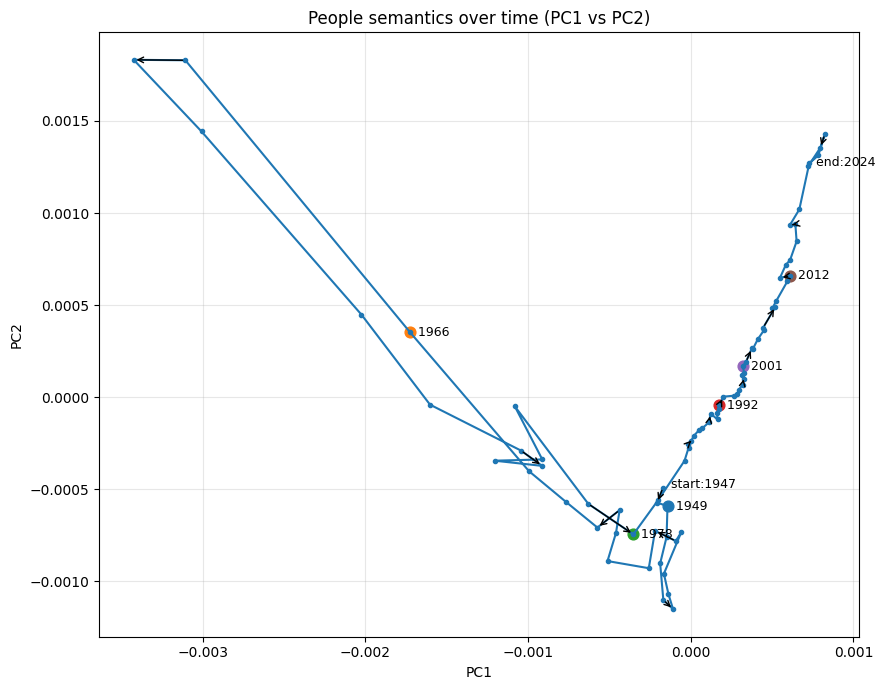

In [7]:
# ==== Plot A: 2D trajectory of "people" semantics over time (PC1-PC2) ====
import matplotlib.pyplot as plt

# If you already have pca2_out as a DataFrame[year:int, PC1:double, PC2:double]
pdf = (pca2_out
       .orderBy("year")
       .toPandas())

years = pdf["year"].tolist()
x = pdf["PC1"].values
y = pdf["PC2"].values

plt.figure(figsize=(9, 7))
# path line
plt.plot(x, y, linewidth=1.5, marker="o", markersize=3)

# arrows between every N years to indicate direction
N = max(1, len(years)//15)  # thin arrows automatically
for i in range(0, len(x)-1, N):
    plt.annotate("",
                 xy=(x[i+1], y[i+1]),
                 xytext=(x[i], y[i]),
                 arrowprops=dict(arrowstyle="->", lw=1))

# highlight milestone years (edit as you like)
milestones = [1949, 1966, 1978, 1992, 2001, 2012]
for m in milestones:
    if m in years:
        j = years.index(m)
        plt.scatter(x[j], y[j], s=60)
        plt.text(x[j], y[j], f"  {m}", va="center", fontsize=9)

# start/end labels
plt.text(x[0], y[0], f"  start:{years[0]}", fontsize=9)
plt.text(x[-1], y[-1], f"  end:{years[-1]}", fontsize=9)

plt.title("People semantics over time (PC1 vs PC2)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# (Optional) save
# plt.savefig("people_semantics_pc12_trajectory.png", dpi=180)


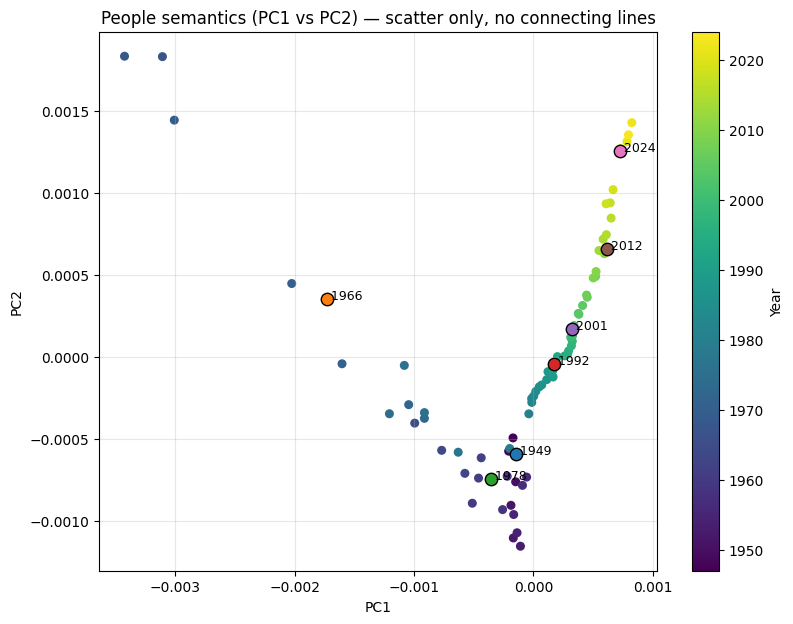

In [8]:
import matplotlib.pyplot as plt

pdf = pca2_out.orderBy("year").toPandas()
years = pdf["year"].values
x = pdf["PC1"].values
y = pdf["PC2"].values

plt.figure(figsize=(9, 7))
plt.scatter(x, y, c=years, cmap='viridis', s=30)  # 用年份映射颜色渐变
plt.colorbar(label="Year")

# 标出关键年份
milestones = [1949, 1966, 1978, 1992, 2001, 2012, 2024]
for m in milestones:
    if m in years:
        i = list(years).index(m)
        plt.scatter(x[i], y[i], s=80, edgecolor='k', label=str(m))
        plt.text(x[i], y[i], f" {m}", fontsize=9)

plt.title("People semantics (PC1 vs PC2) — scatter only, no connecting lines")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(alpha=0.3)
plt.show()


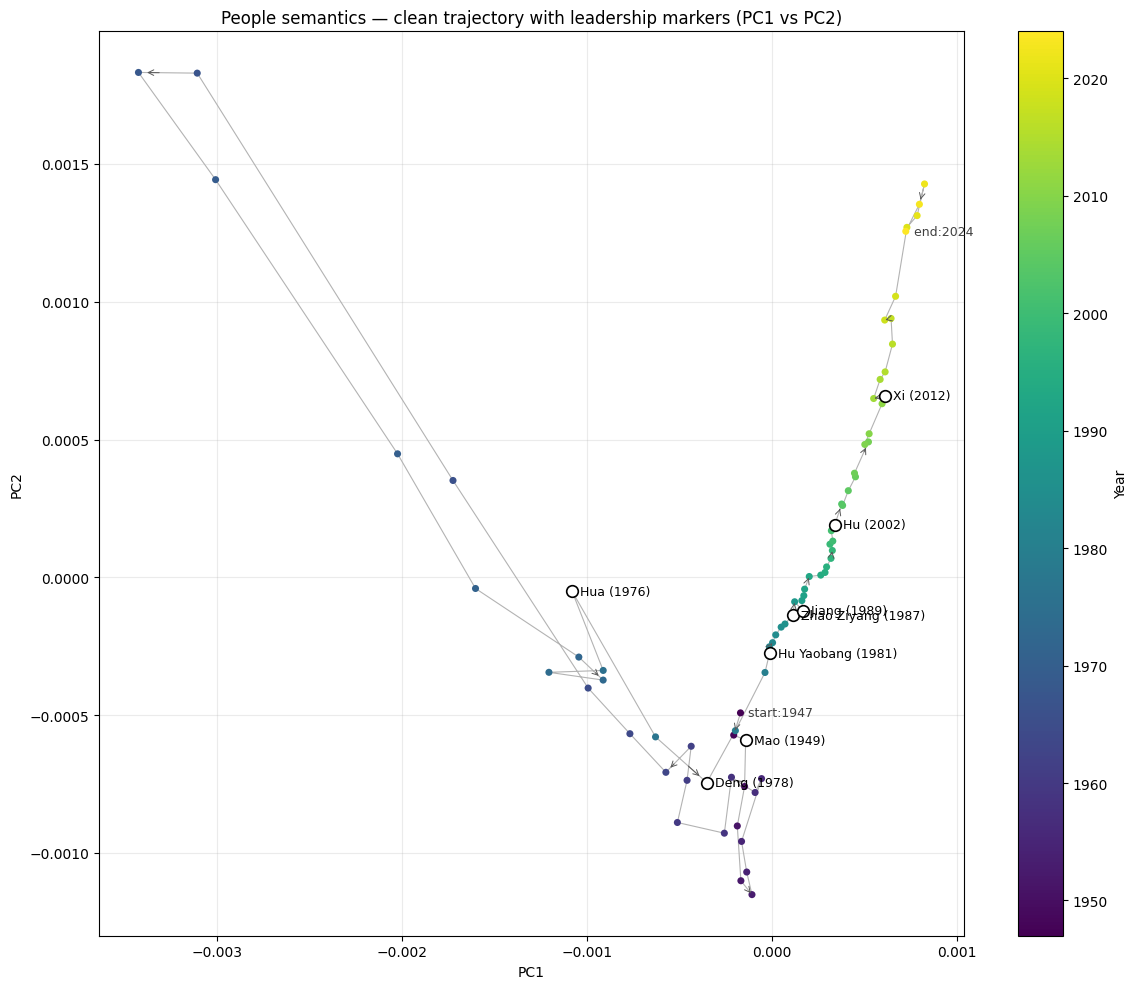

In [13]:
# ===== Clean PC1–PC2 "semantic trajectory" with leadership markers =====
import numpy as np
import matplotlib.pyplot as plt

# 1) data
pdf = pca2_out.orderBy("year").toPandas()
years = pdf["year"].to_numpy()
x = pdf["PC1"].to_numpy()
y = pdf["PC2"].to_numpy()

# 2) 领导人更迭 / 上台 / 换届（可自行增删）
leaders = {
    1949: "Mao (1949)",
    1976: "Hua (1976)",
    1978: "Deng (1978)",
    1981: "Hu Yaobang (1981)",
    1987: "Zhao Ziyang (1987)",
    1989: "Jiang (1989)",
    2002: "Hu (2002)",
    2012: "Xi (2012)"
}

# 3) base scatter with year colormap
plt.figure(figsize=(12, 10))
sc = plt.scatter(x, y, c=years, cmap="viridis", s=26, zorder=3, linewidths=0)
cbar = plt.colorbar(sc); cbar.set_label("Year")

# 4) thin polyline (order by year)
plt.plot(x, y, color="0.7", linewidth=0.8, zorder=2)

# 5) tiny direction arrows every k years along the raw polyline
k = 5  # arrow density; set to 3/5/10 as you like
for i in range(0, len(years)-1, k):
    dx = x[i+1] - x[i]
    dy = y[i+1] - y[i]
    # very small proportional arrows
    plt.annotate("",
                 xy=(x[i] + dx*0.9, y[i] + dy*0.9),
                 xytext=(x[i] + dx*0.6, y[i] + dy*0.6),
                 arrowprops=dict(arrowstyle="->", lw=0.7, color="0.35"),
                 zorder=4)

# 6) highlight leadership change years
for ymark, label in leaders.items():
    if ymark in years:
        idx = int(np.where(years == ymark)[0][0])
        plt.scatter(x[idx], y[idx],
                    s=70, facecolor="white", edgecolor="black", linewidths=1.2, zorder=5)
        plt.text(x[idx], y[idx], f"  {label}", fontsize=9, va="center", zorder=6)

# 7) start / end
plt.text(x[0],  y[0],  f"  start:{years[0]}", fontsize=9, va="center", color="0.25")
plt.text(x[-1], y[-1], f"  end:{years[-1]}",  fontsize=9, va="center", color="0.25")

plt.title("People semantics — clean trajectory with leadership markers (PC1 vs PC2)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()
# plt.savefig("people_semantics_pc12_leadership_marked.png", dpi=180)


In [23]:
# --- A1) Reload Spark & your saved doc embeddings ---
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.stat import Summarizer

spark = (SparkSession.builder
         .appName("resume_from_docs_svd")
         .getOrCreate())

docs_svd = spark.read.parquet("output_docs_svd")  # [year:int, doc_vec_k: array<double>]

# Convert array<double> to Vector
to_vec = F.udf(lambda xs: Vectors.dense(xs), VectorUDT())
docs_svd_vec = docs_svd.withColumn("doc_vec", to_vec(F.col("doc_vec_k")))

# --- A2) Yearly mean vectors ---
s = Summarizer.metrics("mean")
year_vecs = (docs_svd_vec
             .groupBy("year")
             .agg(s.summary(F.col("doc_vec")).alias("summary"))
             .select(F.col("year").cast("int").alias("year"),
                     F.col("summary.mean").alias("year_vec"))
             .orderBy("year"))

# --- A3) PCA to 2D (PC1, PC2) ---
pca_input = year_vecs.select(F.col("year"), F.col("year_vec").alias("features"))
pca2 = PCA(k=2, inputCol="features", outputCol="pca_features")
pca2_model = pca2.fit(pca_input)

from pyspark.ml.functions import vector_to_array
pca2_out = (pca2_model.transform(pca_input)
            .withColumn("pca_arr", vector_to_array("pca_features"))
            .withColumn("PC1", F.col("pca_arr")[0])
            .withColumn("PC2", F.col("pca_arr")[1])
            .select("year", "PC1", "PC2")
            .orderBy("year"))
pca2_out.show(10, truncate=False)


25/11/03 17:01:29 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


[Stage 109:==================================================>    (35 + 3) / 38]

+----+----------------------+----------------------+
|year|PC1                   |PC2                   |
+----+----------------------+----------------------+
|1947|-1.7111756994768576E-4|-4.921422441337365E-4 |
|1948|-2.076825001077487E-4 |-5.727761812297213E-4 |
|1949|-1.4313575750083698E-4|-5.912140623611234E-4 |
|1950|-1.4899534790851018E-4|-7.593038955043643E-4 |
|1951|-1.8830795400565485E-4|-9.025513588262942E-4 |
|1952|-1.6887453420343188E-4|-0.0011013155566301175|
|1953|-1.0901850520179663E-4|-0.001151692383610612 |
|1954|-1.373866724364709E-4 |-0.001069726582971439 |
|1955|-1.6537787663033134E-4|-9.586126892933131E-4 |
|1956|-5.7261082268204015E-5|-7.306722158658722E-4 |
+----+----------------------+----------------------+
only showing top 10 rows



In [29]:
# --- B1) Rebuild TF-IDF on docs containing "人民" (same filters as before) ---
from pyspark.sql import functions as F
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.ml.functions import vector_to_array
import numpy as np

# If you don't have `df` in memory, reload your base parquet first:
base = "cleaned_segmented_parquet"
df = spark.read.parquet(base).select(
    F.col("年份").cast("int").alias("year"),
    F.col("文本内容_清洗").alias("content_cleaned")
)

docs = (df
    .filter(F.col("content_cleaned").isNotNull())
    .filter(F.length(F.trim(F.col("content_cleaned"))) > 0)
    .filter(F.instr(F.col("content_cleaned"), "人民") > 0)
    .select("year", "content_cleaned"))

docs_tok = (docs
    .withColumn("tokens", F.split(F.col("content_cleaned"), r"\s+"))
    .withColumn("tokens", F.expr("filter(tokens, x -> x REGEXP '^[\\u4e00-\\u9fa5]+$' AND length(x) >= 2)")))

cv = CountVectorizer(inputCol="tokens", outputCol="tf", vocabSize=50000, minDF=50)
cv_model = cv.fit(docs_tok)
docs_tf = cv_model.transform(docs_tok)

idf = IDF(inputCol="tf", outputCol="tfidf")
idf_model = idf.fit(docs_tf)
docs_tfidf = idf_model.transform(docs_tf).select("year", "tfidf")

# --- B2) Yearly mean TF-IDF vector (robust way using Summarizer) ---
from pyspark.ml.stat import Summarizer
from pyspark.ml.functions import vector_to_array
from pyspark.sql import functions as F
import numpy as np

# docs_tfidf: [year:int, tfidf: Vector]  <-- from your earlier steps
s = Summarizer.metrics("mean")

year_mean_vec = (
    docs_tfidf
    .groupBy("year")
    .agg(s.summary(F.col("tfidf")).alias("sum"))
    .select(
        F.col("year").cast("int").alias("year"),
        F.col("sum.mean").alias("mean_vec")   # Vector
    )
    .orderBy("year")
)

# Convert the mean vector to array<double> for NumPy
year_mean_arr = year_mean_vec.withColumn("mean_arr", vector_to_array("mean_vec"))

# Collect to driver as a (Y × V) matrix
rows = year_mean_arr.select("year", "mean_arr").orderBy("year").collect()
years_tf = [int(r["year"]) for r in rows]
Y = np.stack([np.array(r["mean_arr"], dtype=float) for r in rows], axis=0)  # shape: (Y, V)

# --- Align with PCA years and compute correlations ---
pdf = pca2_out.orderBy("year").toPandas()
pc_years = pdf["year"].tolist()
pc1 = pdf["PC1"].to_numpy()
pc2 = pdf["PC2"].to_numpy()

# align rows in Y to PCA years (in case of mismatch)
year_to_idx = {y:i for i, y in enumerate(years_tf)}
keep = [year_to_idx[y] for y in pc_years if y in year_to_idx]
Y_aligned = Y[keep, :]
pc1 = pc1[[i for i,y in enumerate(pc_years) if y in year_to_idx]]
pc2 = pc2[[i for i,y in enumerate(pc_years) if y in year_to_idx]]

def corr_with_pc(Ymat, pc):
    y = Ymat - Ymat.mean(axis=0, keepdims=True)
    x = pc - pc.mean()
    num = (y * x[:, None]).sum(axis=0)
    den = np.sqrt((y**2).sum(axis=0)) * np.sqrt((x**2).sum())
    return np.divide(num, den, out=np.zeros_like(num), where=den>0)

corr1 = corr_with_pc(Y_aligned, pc1)
corr2 = corr_with_pc(Y_aligned, pc2)

def top_corr(corr, vocab, topn=30):
    order = np.argsort(corr)
    neg = [(vocab[i], float(corr[i])) for i in order[:topn]]
    pos = [(vocab[i], float(corr[i])) for i in order[::-1][:topn]]
    return pos, neg

vocab = cv_model.vocabulary
pc1_pos, pc1_neg = top_corr(corr1, vocab, topn=30)
pc2_pos, pc2_neg = top_corr(corr2, vocab, topn=30)

def print_axis(name, pos, neg, width=12):
    print(f"\n=== {name} (Top corr + / - terms) ===")
    for i in range(min(len(pos), len(neg))):
        p_term, p_val = pos[i]
        n_term, n_val = neg[i]
        print(f"{p_term:<{width}} {p_val:>+7.3f}    {n_term:<{width}} {n_val:>+7.3f}")

print_axis("PC1", pc1_pos, pc1_neg)
print_axis("PC2", pc2_pos, pc2_neg)


25/11/03 17:09:22 WARN DAGScheduler: Broadcasting large task binary with size 1371.4 KiB


25/11/03 17:09:39 WARN DAGScheduler: Broadcasting large task binary with size 1375.5 KiB
25/11/03 17:09:39 WARN DAGScheduler: Broadcasting large task binary with size 1377.7 KiB
25/11/03 17:09:39 WARN DAGScheduler: Broadcasting large task binary with size 1380.2 KiB



=== PC1 (Top corr + / - terms) ===
经营            +0.819    挣扎            -0.938
正式            +0.798    迎头痛击          -0.937
列入            +0.797    举着            -0.932
精美            +0.793    革命            -0.931
希望            +0.791    烈火            -0.930
而成            +0.789    灭亡            -0.926
部门            +0.788    胜利            -0.926
经济            +0.784    之流            -0.925
用于            +0.778    敌人            -0.925
至今            +0.778    搏斗            -0.921
列为            +0.776    狠狠            -0.921
参照            +0.771    怀着            -0.921
得以            +0.769    人民之声          -0.920
具备            +0.769    高呼            -0.920
令人            +0.768    沉重打击          -0.920
第一部           +0.767    甘心            -0.919
进展            +0.764    革命斗争          -0.918
总额            +0.762    阶级            -0.917
改善            +0.761    群众斗争          -0.917
特有            +0.759    霍查            -0.917
资金            +0.759    丑剧            -0.916
依据            +0.75

In [35]:
from pyspark.ml.feature import PCA
from pyspark.sql import functions as F

# 1) 设一个稍大的 k，例如 20，保证足够覆盖大部分方差
pca_k = 20  
pcaN = PCA(k=pca_k, inputCol="features", outputCol="pca_features")
pca_model = pcaN.fit(pca_input)

# 2) 取解释方差（variance ratio）
explained = pca_model.explainedVariance.toArray()
import numpy as np
cum = np.cumsum(explained)

# 3) 自动选出使累计解释率超过 threshold （例如 0.85）
threshold = 0.85
k_opt = np.argmax(cum >= threshold) + 1  # 保证从1开始计数，例如返回3则代表PC1~PC3

print("每个PC解释率:", explained)
print("累计解释率:", cum)
print("✅ 自动选择的主成分个数（k）:", k_opt)


每个PC解释率: [0.18503624 0.12799043 0.09455507 0.08599124 0.06548074 0.05331942
 0.04111306 0.03562737 0.03319124 0.02982911 0.02310498 0.02264237
 0.02063794 0.01647242 0.01438324 0.01289036 0.0115135  0.01079069
 0.00916157 0.0074984 ]
累计解释率: [0.18503624 0.31302667 0.40758174 0.49357298 0.55905373 0.61237314
 0.65348621 0.68911357 0.72230481 0.75213392 0.7752389  0.79788127
 0.81851921 0.83499163 0.84937487 0.86226523 0.87377873 0.88456941
 0.89373099 0.90122939]
✅ 自动选择的主成分个数（k）: 16


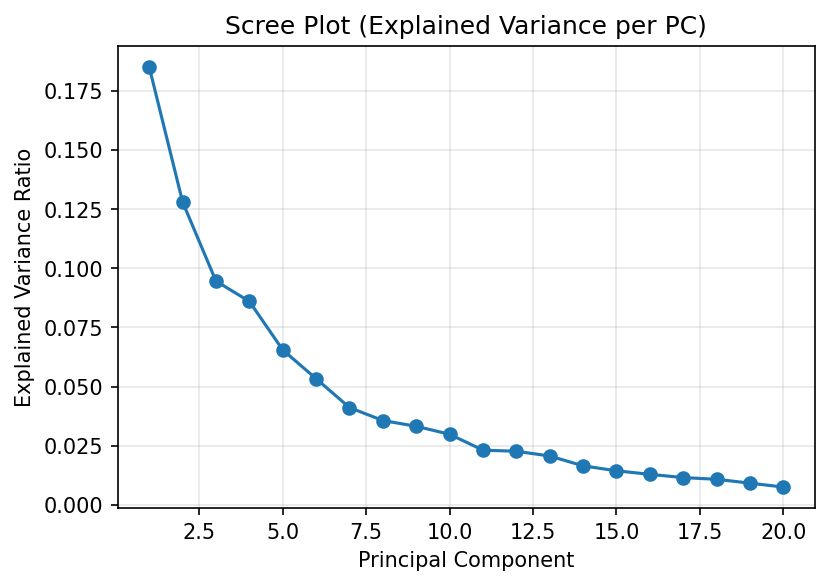

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(range(1, len(explained)+1), explained, marker='o')
plt.title("Scree Plot (Explained Variance per PC)")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.grid(alpha=0.3)
plt.show()
